In [ ]:
pip install -q tfds-nightly

In [ ]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("TensorFlow version: {}".format(tf.__version__))
print("TensorFlow Datasets version: ",tfds.__version__)

In [ ]:
ds_preview, info = tfds.load('penguins/simple', split='train', with_info=True)
df = tfds.as_dataframe(ds_preview.take(5), info)
print(df)
print(info.features)

In [4]:
class_names = ['Adélie', 'Chinstrap', 'Gentoo']

In [ ]:
ds_split, info = tfds.load("penguins/processed", split=['train[:20%]', 'train[20%:]'], as_supervised=True, with_info=True)

ds_test = ds_split[0]
ds_train = ds_split[1]
assert isinstance(ds_test, tf.data.Dataset)

print(info.features)
df_test = tfds.as_dataframe(ds_test.take(5), info)
print("Test dataset sample: ")
print(df_test)

df_train = tfds.as_dataframe(ds_train.take(5), info)
print("Train dataset sample: ")
print(df_train)

ds_train_batch = ds_train.batch(32)

In [6]:
features, labels = next(iter(ds_train_batch))

print(features)
print(labels)

tf.Tensor(
[[0.49818182 0.6904762  0.42372882 0.4027778 ]
 [0.48       0.07142857 0.6440678  0.44444445]
 [0.7236364  0.9047619  0.6440678  0.5833333 ]
 [0.34545454 0.5833333  0.33898306 0.3472222 ]
 [0.10909091 0.75       0.3559322  0.41666666]
 [0.6690909  0.63095236 0.47457626 0.19444445]
 [0.8036364  0.9166667  0.4915254  0.44444445]
 [0.4909091  0.75       0.37288135 0.22916667]
 [0.33454546 0.85714287 0.37288135 0.2361111 ]
 [0.32       0.41666666 0.2542373  0.1388889 ]
 [0.41454545 0.5952381  0.5084746  0.19444445]
 [0.14909092 0.48809522 0.2542373  0.125     ]
 [0.23636363 0.4642857  0.27118644 0.05555556]
 [0.22181818 0.5952381  0.22033899 0.3472222 ]
 [0.24727273 0.5595238  0.15254237 0.25694445]
 [0.63272727 0.35714287 0.88135594 0.8194444 ]
 [0.47272727 0.15476191 0.6440678  0.4722222 ]
 [0.6036364  0.23809524 0.84745765 0.7361111 ]
 [0.26909092 0.5595238  0.27118644 0.16666667]
 [0.28       0.71428573 0.20338982 0.5416667 ]
 [0.10545454 0.5714286  0.33898306 0.2847222 ]
 [

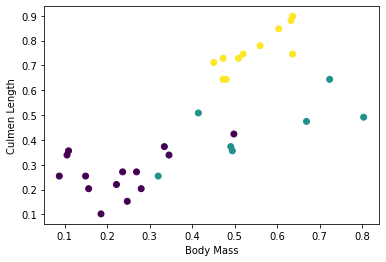

In [7]:
plt.scatter(features[:,0],
            features[:,2],
            c=labels,
            cmap='viridis')

plt.xlabel("Body Mass")
plt.ylabel("Culmen Length")
plt.show()

In [8]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

In [9]:
predictions = model(features)
predictions[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[ 0.4131384 , -0.06038465, -0.31464267],
       [ 0.34150514, -0.05236582, -0.22752024],
       [ 0.5732902 , -0.10930613, -0.43913797],
       [ 0.32858682, -0.06969736, -0.2551392 ],
       [ 0.33545256, -0.23310952, -0.3116657 ]], dtype=float32)>

In [10]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.47488257, 0.29575887, 0.22935855],
       [0.44632533, 0.30102015, 0.25265446],
       [0.53514886, 0.27041253, 0.19443867],
       [0.4485739 , 0.30120444, 0.2502217 ],
       [0.4784937 , 0.27098975, 0.2505165 ]], dtype=float32)>

In [11]:
print("Prediction: {}".format(tf.math.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
    Labels: [0 2 1 0 0 1 1 1 0 1 1 0 0 0 0 2 2 2 0 0 0 0 2 2 1 2 0 2 2 2 2 0]


In [12]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [13]:
def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)

l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))

Loss test: 1.1404691934585571


In [14]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [15]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [16]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels, training=True).numpy()))

Step: 0, Initial Loss: 1.1404691934585571
Step: 1,         Loss: 1.1384495496749878


In [17]:
## Note: Rerunning this cell uses the same model parameters

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  
  for x, y in ds_train_batch:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    epoch_loss_avg.update_state(loss_value)  
    epoch_accuracy.update_state(y, model(x, training=True))


  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.125, Accuracy: 44.944%
Epoch 050: Loss: 0.785, Accuracy: 80.150%
Epoch 100: Loss: 0.414, Accuracy: 84.644%
Epoch 150: Loss: 0.222, Accuracy: 96.255%
Epoch 200: Loss: 0.136, Accuracy: 97.378%


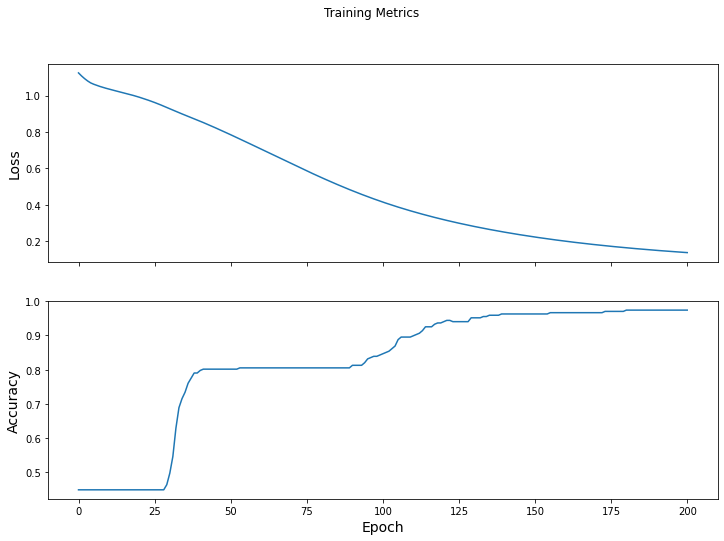

In [18]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [19]:
test_accuracy = tf.keras.metrics.Accuracy()
ds_test_batch = ds_test.batch(10)

for (x, y) in ds_test_batch:
 
  logits = model(x, training=False)
  prediction = tf.math.argmax(logits, axis=1, output_type=tf.int64)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 97.015%


In [20]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: shape=(7, 2), dtype=int64, numpy=
array([[1, 1],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [0, 0]])>

In [21]:
predict_dataset = tf.convert_to_tensor([
    [0.3, 0.8, 0.4, 0.5,],
    [0.4, 0.1, 0.8, 0.5,],
    [0.7, 0.9, 0.8, 0.4]
])


predictions = model(predict_dataset, training=False)

for i, logits in enumerate(predictions):
  class_idx = tf.math.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Adélie (93.8%)
Example 1 prediction: Gentoo (95.8%)
Example 2 prediction: Chinstrap (86.8%)
